<a href="https://colab.research.google.com/gist/bwasti/a85d3770aa66877c4a9bcf1352ab2c9d/loop_tool_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is `loop_tool`?

`loop_tool` is a work-in-progress experimental linear algebra toolkit.  Here's the code: https://github.com/facebookresearch/loop_tool.

### Design
The frontend is designed to provide an unsurprising lazy and symbolic interaction model.  The backend API focuses on empowering compilers
to emit high performance code without requiring an investment in operator coverage.

```python
def vecmatmul(a, b):
  N, K = lt.Symbol("N"), lt.Symbol("K")
  return (a.to(K) * b.to(K, N)).sum(K)
```

By keeping the frontend entirely lazy and symbolic,
the user has access to many modern conviences such as
an imperative interface and named dimensions.  Backends
can perform complex optimizations without needing to
hamper the user with language constraints or requiring user provided annotations.

### Tutorial below

This tutorial is written to review some ideas in the design of `loop_tool`.  Currently there is only an CPU interpreted backend and a simple GPU CUDA backend.  These will continue to be developed with the goal of improving performance and supported arithmetic operations.

In [ ]:
!pip install loop_tool_py numpy

     |████████████████████████████████| 378 kB 13.6 MB/s 
     |████████████████████████████████| 207 kB 55.7 MB/s 


In [ ]:
import loop_tool_py as lt
import numpy as np

print(lt.backends())

['cpu', 'cuda']


First, we load up `loop_tool` and `numpy`.

If only `'cpu'` is availabe, click "Runtime > Change runtime type" and select Hardware accelerator > GPU and rerun the first two cells.

In [ ]:
a = lt.Tensor(128)
b = lt.Tensor(128)

a.set(np.ones(128))
b.set(np.ones(128))
c = a + b

print(c.numpy())
print(c.shape)

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
[128, 128]


Wait, what?

Pointwise addition doesn't seem to work as expected.  `c` isn't a flat tensor of size 128, but rather a 2d tensor of shape (128, 128).

Every dimension in `loop_tool` is named.
Since we didn't explicitly name the dimensions of `a` and `b`, it assumes they operate on different dimensions.  As a result, it broadcasts
`a` into (128, 128) and `b` into (128, 128) before doing the addition.

Rather than specifying names upfront, which can become difficult to plan,
`loop_tool` exposes an idea of renaming.  Using `lt.Symbol`s and the `to()` method, we can rename tensor dimensions on the fly:

In [ ]:
N = lt.Symbol("N")
c = a.to(N) + b.to(N)
print(c.numpy())
print(c.shape)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2.]
[128]


With implicit broadcasting and on-the-fly renaming, we can define more complex operations.  For example, a matrix multiplication:

In [ ]:
def mm(a, b):
  M, N, K = lt.Symbol("M"), lt.Symbol("N"), lt.Symbol("K")
  c = a.to(M, K) * b.to(K, N)
  return c.sum(K)

x = lt.Tensor(128,128)
y = lt.Tensor(128,128)
x.set(np.random.randn(128,128))
y.set(np.random.randn(128,128))

z = mm(x, y)
z_ref = x.numpy() @ y.numpy()
print("max error", np.max(np.abs(z.numpy() - z_ref)))

max error 1.5258789e-05


The above matrix multiplication broadcasts the inputs, which are both (128, 128), into an intermediate result (128, 128, 128) and then sums over
the K dimension.

Symbolic naming is a large part of the `loop_tool` design.  We can go beyond implicit broadcasting by introducing "views" that map indices symbolically.
Note that a view in `loop_tool` differs from a view in frameworks like numpy and PyTorch due to the symbolic nature.

For example, a 1d convolution (err "correlation").

In [ ]:
def conv(x, w):
  Ni, No, K = lt.Symbol("Ni"), lt.Symbol("No"), lt.Symbol("K")
  # quick renames
  x = x.to(Ni)
  w = w.to(K)

  # our "view" operation gives xcol the shape (No, K)
  # by indexing into Ni with the equation No + K.
  xcol = x.to(No, K, constraints=[(Ni, No + K)])

  return (xcol * w).sum(K)

x = lt.Tensor(128)
w = lt.Tensor(5)
x.set(np.random.randn(128))
w.set(np.random.randn(5))

y = conv(x, w)
y_ref = np.correlate(x.numpy(), w.numpy(), mode="valid")
print("max error", np.max(np.abs(z.numpy() - z_ref)))

max error 1.5258789e-05


The above implementation of convolution looks a lot like matrix multiplication.  We have a broadcasting multiplication followed by a reduction (by addition).

The "view" operation is hidden within the `to` call as a `constraint=` parameter.  It makes our 1d (`Ni`) dimension into 2d (`No`, `K`) with the indexing math provided.  It's a symbolic "im2col" that gives us the classic "sweeping" operation.

Because `loop_tool` defines its views symbolically, there are some interesting and potentially useful implications.

In [ ]:
_ = lt.Symbol("unknown")
a = lt.Tensor(_)
b = lt.Tensor(3)
c = lt.Tensor(8)
N = lt.Symbol("N")
d = (conv(a, b).to(N) * c.to(N)).sum(N)
d.unify()
print(a.shape)

[10]


We can derive input shapes from constraints induced by the operations on the inputs.

In this example we have a convolution followed by a pointwise multiplication, which implies our output must be size 8.  The windowed operation is size 3, so the input must be 10.  Since `loop_tool` is secretly lazy, it can figure this out for us before running any computation.

# Under the hood

The above implementations of matrix multiplication and convolution
don't seem very efficient.
Broadcasting a (128,128) tensor into (128,128,128) just to do
some pointwise multiplication in `mm` is a huge waste of space.  Same for (128) to (128,5) in the case of `conv`.

Zooming into the matrix multiplication, we can take a peek under the hood
using `z.loop_tree`:



In [ ]:
print(z.loop_tree)

for M_51 in 128 : L0
 for K_53 in 128 : L1
  %0[M_51, K_53] <- read()
  for N_52 in 128 : L3
   %1[K_53, N_52] <- read()
   %2[M_51, K_53, N_52] <- multiply(%0, %1)
   %3[M_51, N_52] <- add(%2)
 for N_52 in 128 : L7
  %4[M_51, N_52] <- write(%3)



and, similarly for conv:

In [ ]:
print(y.loop_tree)

for Ni_88 in 128 : L0
 %0[Ni_88] <- read()
for K_90 in 5 : L2
 %2[K_90] <- read()
for No_89 in 124 : L4
 for K_90 in 5 : L5
  %1[No_89, K_90] <- view(%0)
  %3[No_89, K_90] <- multiply(%1, %2)
  %4[No_89] <- add(%3)
 %5[No_89] <- write(%4)



Although the API hides it, `loop_tool` tensors are not really data.  Before calling `z.numpy()`, nothing was computed.  The tensors of `loop_tool` are symbolic computation graphs.  They contain symbolic information that can be used to generate compiled code.

The `z.loop_tree` is a result of a simplistic scheduling of the IR.  The IR itself can be viewed as a graphviz file:

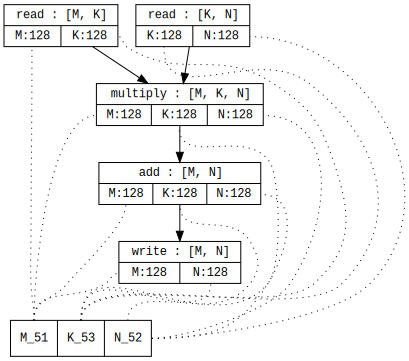

In [ ]:
import graphviz
g = graphviz.Source(z.ir)
g

*Since we often reuse names in code (e.g. by calling `mm` twice), `loop_tool` automatically appends a unique ID to each generated symbol.  This can make it hard to read, so the graphviz has dotted lines mapping the simple names (used by the user) to the full names of the symbols (including ID).*

# Manipulating the IR

Let's jump into how a backend might optimize the execution of operations defined in `loop_tool`. Matrix multiplication and convolution are complex optimization problems, so for the sake of the tutorial we will stick with a simple pointwise operation.

`loop_tool` IR is extremely cheap to copy.  It stores the information in a dense format that can be cloned easily (using builtin copy constructors).  That means a lot of the IR manipulation can involve copies being made of the IR.  Although this isn't strictly necessary, the copies make it easy to save state and search through many different manipulations in a trivially parallel way.  Keep this in mind as copies will be made without explicitly mentioning it in the comments below.

Before that, let's set the backend to "cuda" if it's available.  CPU is fine as well (there is multithreading we can tune).

In [ ]:
N = 1024 # problem size

backend = "cpu"
if "cuda" in lt.backends():
  backend = "cuda"
  lt.set_default_hardware("cuda")
  lt.set_default_backend("cuda")
  N *= 1024 # bigger if we have a GPU
else:
  lt.set_default_hardware("cpu")
  lt.set_default_backend("cpu")

Then we can define the problem

In [ ]:
v = lt.Symbol('v')
a = lt.Tensor(N)
b = lt.Tensor(N)
a.set(np.random.randn(N))
b.set(np.random.randn(N))

c = a.to(v) + b.to(v)
print(c.loop_tree)
print(c.numpy())

for v_269 in 1048576 : L0
 %0[v_269] <- read()
 %1[v_269] <- read()
 %2[v_269] <- add(%0, %1)
 %3[v_269] <- write(%2)

[ 2.0317874  -1.0940161   1.1519554  ... -3.1566718  -0.17415054
  2.1214528 ]


We define a benchmark using the `resolve()` method, which forces data to be calculated but doesn't copy it to a numpy array.

In [ ]:
import time

def bench(warmup, iters):
  v = lt.Symbol('v')
  a = lt.Tensor(N)
  b = lt.Tensor(N)
  a.set(np.random.randn(N))
  b.set(np.random.randn(N))

  for i in range(warmup):
    c = a.to(v) + b.to(v)
    c.resolve()
  t1 = time.time()
  for i in range(iters):
    c = a.to(v) + b.to(v)
    c.resolve()
  t2 = time.time()
  print(f"{iters / (t2 - t1):.2f} iters/sec")

In [ ]:
bench(10, 10)

12.59 iters/sec


Not great.  Let's parallelize the loop_tree and feed it back into `c` with the `set()` method.  This will cause all future additions of the same shape to use the user provided loop_tree.  Both the CPU and CUDA backends happen to understand the "parallel" annotation, but custom backends could always use different strings.

In [ ]:
loop_tree = c.loop_tree # copied :)
loop_tree.annotate(loop_tree.loops[0], "parallel")
c.set(loop_tree)
bench(10, 1000)

833.20 iters/sec


Better on GPU, worse on CPU (because 1024 threads just got spawned).  Let's check out the loop_tree:

In [ ]:
print(c.loop_tree)

for v_269 in 1048576 : L0 parallel
 %0[v_269] <- read()
 %1[v_269] <- read()
 %2[v_269] <- add(%0, %1)
 %3[v_269] <- write(%2)



Simple annotations like "parallel" are done on the loop_tree, but more advanced scheduling it done on the IR itself.  This includes loop splitting and reordering.  If we dump the IR we can see what's going on:

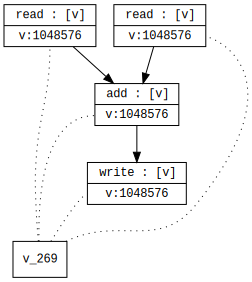

In [ ]:
ir = c.ir # copied :)
graphviz.Source(ir)

Besides visual inspection, we can also iterate through nodes with code.  Here's an example:

In [ ]:
for n in ir.nodes:
  print(n, ir.pointwise_vars(n))

0 [0]
1 [0]
2 [0]
3 [0]


It's all useless numbers!  This is because the Python API closely mirrors the C++ API and both work with node and variable "references" for efficiency.  To get readable names, we have to ask the IR what the names are:

In [ ]:
for n in ir.nodes:
  print(ir.dump(n), [ir.dump_var(v) for v in ir.pointwise_vars(n)])

%0[v_269] <- read() ['v_269']
%1[v_269] <- read() ['v_269']
%2[v_269] <- add(%0, %1) ['v_269']
%3[v_269] <- write(%2) ['v_269']


Now we can manipulate the loops by annotating each node with a loop order.  Note that we are splitting the variable 'v' in the process.  This IR annotation, `set_order` covers a vast majority of usecases:

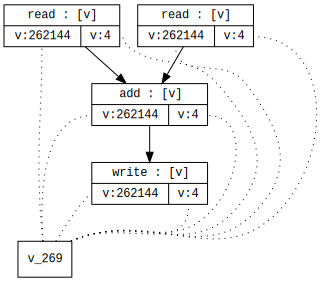

In [ ]:
assert len(ir.vars) == 1
v = ir.vars[0]

for n in ir.nodes:
  inner = 4
  ir.set_order(n, [(v, (N // inner, N % inner)), (v, (inner, 0))])
graphviz.Source(ir)


We can inspect the resultant loop_tree by creating a new one from the IR with `lt.LoopTree(ir)`:

In [ ]:
loop_tree = lt.LoopTree(ir)
print(loop_tree)

for v_269 in 262144 : L0
 for v_269' in 4 : L1
  %0[v_269] <- read()
  %1[v_269] <- read()
  %2[v_269] <- add(%0, %1)
  %3[v_269] <- write(%2)



Since each node had the same loop orders and loop splits, they were automatically coalesced into a single loop nest.  This reduces iterations and memory pressure on the system.  If we were to artificially induce "mismatches" by setting alternating nodes to have different loop orders, we see many different loop nests:

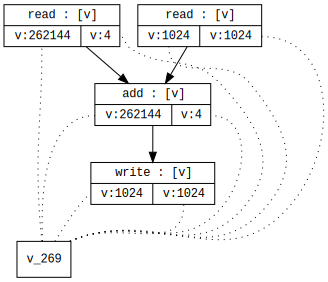

In [ ]:
alternate = True
for n in ir.nodes:
  alternate = not alternate
  inner = 4
  if alternate:
    inner = N // 1024
  ir.set_order(n, [(v, (N // inner, N % inner)), (v, (inner, 0))])
graphviz.Source(ir)

In [ ]:
loop_tree = lt.LoopTree(ir)
print(loop_tree)
print("bad schedule :( let's change it")

for v_269 in 262144 : L0
 for v_269' in 4 : L1
  %0[v_269] <- read()
for v_269 in 1024 : L3
 for v_269' in 1024 : L4
  %1[v_269] <- read()
for v_269 in 262144 : L6
 for v_269' in 4 : L7
  %2[v_269] <- add(%0, %1)
for v_269 in 1024 : L9
 for v_269' in 1024 : L10
  %3[v_269] <- write(%2)

bad schedule :( let's change it


In [ ]:
for n in ir.nodes:
  parallel = 8 * 1024 if backend == "cuda" else 2
  inner = 4 if backend == "cuda" else 512
  size = N // (parallel * inner)
  tail = N % (parallel * inner)
  ir.set_order(n, [(v, (size, tail)), (v, (parallel, 0)), (v, (inner, 0))])

loop_tree = lt.LoopTree(ir)
loop_tree.annotate(loop_tree.loops[1], "parallel")
print(loop_tree)

for v_269 in 32 : L0
 for v_269' in 8192 : L1 parallel
  for v_269'' in 4 : L2
   %0[v_269] <- read()
   %1[v_269] <- read()
   %2[v_269] <- add(%0, %1)
   %3[v_269] <- write(%2)



In [ ]:
c.set(loop_tree)
bench(10, 1000)

848.26 iters/sec


And now we have a faster implementation!

Note that we haven't hit anywhere near peak performance.  Right now the lazy symbolic API syncs GPU calls every run.  If we were to employ a lower level API, we can actually get to peak.  Here's a notebook that'll do just that. https://colab.research.google.com/drive/1rUl23Y4WTSBd-J5dkbn6dNgBU5XA7fMB

# Thanks for reading!

`loop_tool` is still in early stages of development.  There are many planned features on the way, including compiled CPU support and automatic differentiation.

If you'd like to follow along, here's the GitHub repo: https://github.com/facebookresearch/loop_tool 